# Στοιχεία ομάδας
# Ομάδα Β3
# Μπάκος Παναγιώτης ( 03113014 )
# Φώτος Νικόλαος ( 03113122 )

---

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. Σύστημα συστάσεων βασισμένο στο περιεχόμενο - σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

In [1]:
# Απαραίτητα Imports
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
!pip install unidecode
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.externals import joblib
!pip install somoclu
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline
from sklearn.cluster import KMeans

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [2]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_e83bb2ed70e300a3a681580fec6a7d42c6cd8eb2','domain': {'id': 'dd180082cfbb4aba93677ea2bbc9d7ff'},
            'password': 'y]333V2!.D=?Blh='}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

# Your data file was loaded into a StringIO object and you can process the data.
# Please read the documentation of pandas to learn more about your possibilities to load your data.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html
df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'movieDBe.csv'), sep='\t',  header=None, quoting=3)
df_data_2 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'seedb.csv'),  header=None)

Το data frame `df_data_2` έχει 100 γραμμές και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της [εδώ](https://goo.gl/4TuDcA).

In [3]:
team_seed_number = 39
my_index = df_data_2.iloc[team_seed_number,:].values
titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

In [4]:
print '\n\n','Title : ',titles[197][0]
print '\n\n','Categories : ',categories[197][0]
print '\n\n',catbins[197]      
print '\n\n','Summary\n',summaries[197]
print '\n\n','Corpus\n',corpus[197]



Title :  Pojkarna på Storholmen


Categories :  "Comedy",  "Black-and-white"


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=100` θα γράψουμε `print corpus[100]`.

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="50%">

Η πρώτη εφαρμογή που θα αναπτύξουμε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξουμε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus).

---

Αρχικά θα πρέπει να γίνει η προεπεξεργασία των κειμένων της λίστας corpus


# Preprocessing

Αρχικά χρειάζεται να αφαιρέσουμε οποιουσδήποτε non-unicode characters, προκειμένου να μην δημιουργηθούν αργότερα προβλήματα κατά το Stemming & Lemmatization

In [5]:
def remove_non_ascii(text):
    return unidecode(unicode(text, encoding = "utf-8"))

In [6]:
print titles[197]
print 'Original: '+corpus[197][0:58]+'...'

corpus_edited = []
for curr in corpus:
    corpus_edited.append(remove_non_ascii(curr))

print 'Edited  : '+corpus_edited[197][0:57]+'...'

['Pojkarna p\xc3\xa5 Storholmen']
Original: The Sjölund family at Lillholmen Island in the Stockholm ...
Edited  : The Sjolund family at Lillholmen Island in the Stockholm ...


## Επεξεργασία string
Τώρα που φορτώσαμε το κείμενο στην python, πρέπει να το επεξεργαστούμε. Επειδή ο υπολογιστής θεωρεί τα κεφαλαία και τα μικρά ως διαφορετικούς χαρακτήρες, το πρώτο πράγμα που πρέπει να κάνουμε είναι να τα κάνουμε όλα μικρά. Αν και η συγκεκριμένη διαδικασία θα γινόταν και από τον `TfidfVectorizer` αργότερα, την παρουσιάζουμε για λόγους πληρότητας. Έπειτα θέλουμε να χωρίσουμε τις λέξεις μια προς μια, ώστε να φτιάξουμε μια λίστα τα στοιχεία της οποίας θα είναι οι λέξεις. H διεργασία αυτή θα γίνει για κάθε περιγραφή ταινίας ξεχωριστά (ανά corpus[i])

In [7]:
words = []
for i in range(0,len(corpus_edited),1):
    corpus_edited[i] = corpus_edited[i].lower()
    words.append(nltk.word_tokenize(corpus_edited[i]))
    
print 'Edited  : '+corpus_edited[197][0:59]+'...'
print str(words[197][0:9])+ ' ...'

Edited  : the sjolund family at lillholmen island in the stockholm ar...
['the', 'sjolund', 'family', 'at', 'lillholmen', 'island', 'in', 'the', 'stockholm'] ...


Το tokenizer ουσιαστικά κάνει ό,τι και η built-in μέθοδος `.split()` των string, αλλά λίγο πιο έξυπνα. Για αρχή χωρίζει με βάση τόσο τα κενά (' '), όσο και τα tabs ('\t') και τα new lines ('\n'). Επίσης  χωρίζει και τις παρενθέσεις από το περιεχόμενό τους.

Το επόμενο βήμα είναι να διαγράψουμε από τη λίστα μας τα σημεία στίξης. Μόλις το κάνουμε αυτό, θέλουμε να διαγράψουμε και μερικές συχνά χρησιμοποιούμενες λέξεις που δεν προσφέρουν σημασιολογική αξία στο κείμενο (stopwords).

In [8]:
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά

filtered_words = []
for i in range(0,len(words),1):
    filtered_words.append([word for word in words[i] if word not in stopwords.words('english') + list(string.punctuation)])

[nltk_data] Downloading package stopwords to /gpfs/fs01/user/s440-f39b
[nltk_data]     d962225440-fe8dadcb5f83/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Πρέπει να κάνουμε καλύτερη δουλειά στην αφαίρεση των σημείων στίξης γιατί δεν αφαιρούνται οι λέξεις που περιέχουν περισσότερα από ένα τέτοια σημεία.

In [9]:
def thorough_filter_upgraded(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(any(ext in letter for ext in string.punctuation))
        filt=[]
        for i in range(0,len(word),1):
            if not pun[i]:
                filt.append(word[i])
        filtered_words.append(filt)
    return filtered_words
        
new_filtered_words = thorough_filter_upgraded(filtered_words)

Ενδεικτικά ακολουθεί ένα κομμάτι του συγκεκριμένου corpus που δείχνει ότι αφαιρέσαμε σωστά τα puncuation points 

! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~

In [10]:
print 'Original:\n ... '+str(filtered_words[197][5:20]) + ' ...'
print 'Edited:\n ... '+str(new_filtered_words[197][5:18]) + ' ...'

Original:
 ... ['archipelago', 'quite', 'religious', 'therefore', 'regarded', 'suitable', 'place', 'care', '``', 'odd', 'young', 'people', 'adrift', "''", 'placed'] ...
Edited:
 ... ['archipelago', 'quite', 'religious', 'therefore', 'regarded', 'suitable', 'place', 'care', 'odd', 'young', 'people', 'adrift', 'placed'] ...


## Stemming & Lemmatization
Για γραμματικούς λόγους, τα κείμενα χρησιμοποιούν διαφορετικές μορφές μιας λέξης, όπως π.χ. play, plays, playing, played. Αυτό έχει σαν αποτέλεσμα πως, ενώ αναφερόμαστε στην ίδια λέξη, ο υπολογιστής τις καταλαβαίνει ως διαφορετικές. Για να λύσουμε αυτό το πρόβλημα, μπορούμε να χρησιμοποιήσουμε δύο γλωσσολογικούς μετασχηματισμούς, είτε την αφαίρεση της κατάληξης (stemming), είτε τη λημματοποίηση (lemmatization). Ο στόχος, τόσο της αφαίρεσης κατάληξης όσο και της λημματοποίησης, είναι να φέρουν τις διάφορες μορφές της λέξης σε μια κοινή μορφή βάσης. Πιο συγκεκριμένα:

Η αφαίρεση της κατάληξης αναφέρεται σε μια ακατέργαστη ευριστική διαδικασία που απομακρύνει τα άκρα των λέξεων με την ελπίδα να επιτύχει αυτό το στόχο σωστά τις περισσότερες φορές.

Η λημματοποίηση αναφέρεται στην απομάκρυνση της κλίσης των λέξεων και στην επιστροφή της μορφής της λέξης όπως θα τη βρίσκαμε στο λεξικό, με τη χρήση λεξιλογίου και μορφολογικής ανάλυσης των λέξεων. Η μορφή αυτή είναι γνωστή ως λήμμα (lemma).

In [11]:
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

lem_words = []
stem_words = []
for curr in range(0,len(new_filtered_words),1):
    lem_words.append([wordnet_lemmatizer.lemmatize(word) for word in new_filtered_words[curr]])
    stem_words.append([porter_stemmer.stem(word) for word in new_filtered_words[curr]])

print '\n{:<20} {:<20} {:<20}'.format('Original', 'Stemmed', 'Lemmatized')
print '-'*60
print '{:<20} {:<20} {:<20}'.format('...', '...', '...')
for i in range(5,20,1):
    print '{:<20} {:<20} {:<20}'.format(new_filtered_words[197][i], stem_words[197][i], lem_words[197][i])
print '{:<20} {:<20} {:<20}'.format('...', '...', '...')


[nltk_data] Downloading package wordnet to /gpfs/fs01/user/s440-f39bd9
[nltk_data]     62225440-fe8dadcb5f83/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /gpfs/fs01/user/s440-f39bd9622
[nltk_data]     25440-fe8dadcb5f83/nltk_data...
[nltk_data]   Package rslp is already up-to-date!

Original             Stemmed              Lemmatized          
------------------------------------------------------------
...                  ...                  ...                 
archipelago          archipelago          archipelago         
quite                quit                 quite               
religious            religi               religious           
therefore            therefor             therefore           
regarded             regard               regarded            
suitable             suitabl              suitable            
place                place                place               
care                 care  

Τώρα θα δημιουργήσουμε τα τελικά κείμενα που θα αποτελούν την νέα περιγραφή κάθε ταινίας. Επιλέγουμε την έξοδο του Stemmer και όχι του Lemmatizer να δώσει τις νέες περιγραφές των ταινιών μας.

Με τον ακόλουθο κώδικα φέρνουμε τις περιγραφές των ταινιών σε μορφή όμοια με την αρχική. Ενδεικτικά παρουσιάζουμε το description της ταινίας που μας έχει απασχολήσει μέχρι στιγμής. Παρατηρούμε ότι με το preprocessing έχει μειωθεί αρκετά το μέγεθος κάθε κειμένου, καθώς έχουμε ξεφορτωθεί κάθε άχρηστη πληροφορία, επιτρέποντας στο σύστημα αργότερα να εστιάσει στις "σημαντικές" λεπτομέρειες. 

In [12]:
corpus_final = []
for i in range (0,len(stem_words),1):
    corpus_final.append(' '.join(stem_words[i]))

print corpus[197]+'\n'
print corpus_final[197]

The Sjölund family at Lillholmen Island in the Stockholm archipelago is quite religious and has therefore been regarded as a suitable place for the care of "odd young people adrift" who are to be placed there by the "Municipal Protection Society for Young Girls". One day, the fashionable Sonja Waller, a woman with a "questionable reputation", is expected at the island and the Sjölunds are waiting anxiously. Unfortunately, the young handsome Gunnar Andersson of the neighboring Storholmen Island has been sent to get her at a local steamboat bridge. Sonja, who is a pretty girl, immediately makes a great impression on Gunnar, who soon forgets that he is actually engaged to Aina, Sjölund's daughter. As Gunnar wants to show off for the new guest, the boat trip back to the Lillholmen is delayed for more than an hour. Back at the Storholmen Island, the general mood gets tense as all the locals are anxious to have a glimpse of the woman from the big city. After a short while, Ivar  and Sixten ,

Αφότου έχουμε ολοκληρώσει τις γλωσσολογικές προεπεξεργασίες, μπορούμε να προχωρήσουμε στο πρόβλημα της ομαδοποίησης των κειμένων. Πιο συγκεκριμένα θέλουμε να δούμε ποιοι όροι (λέξεις) είναι πιο σημαντικοί για κάθε ομάδα. Πρώτο βήμα όμως είναι η αναπαράσταση των προτάσεων σε διανύσματα.

# TF-IDF
Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται αρχικά δεν είναι βελτιστοποιημένη. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν δραματική επίδραση στην ποιότητα των συστάσεων και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη διαστατικότητα των δεδομένων. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους χρόνους εκπαίδευσης, ιδιαίτερα στη δεύτερη εφαρμογή.

Επιλέξαμε να πειραματιστούμε με τις ακόλουθες παραμέτρους :
    
1. stop_words : Αν και είχαν αφαιρεθεί ήδη οι περισσότερες stop words χειροκίνητα, παρατηρούμε ότι πέφτει κι άλλο η διαστατικότητα εάν αξιοποιήσουμε την αφαίρεση των stop words από τον TfidfVectorizer 
2. min_df : Αγνοεί τους όρους που έχουν μικρότερη συχνότητα εμφάνισης από το ορισμένο "κατώφλι". Οι συγκεκριμένοι όροι θεωρούνται ασήμαντοι επομένως η αφαιρεσή τους δεν θα επηρεάσει την ακρίβεια του recommender system

Για διαφορετικά configurations του `TfidfVectorizer` λαμβάνουμε δεδομένα με τις εξής διαστάσεις. Επιλέγουμε το τελευταίο, καθώς κρατάει τις ελάχιστες παραμέτρους που θα χρειαστούν για τη δημιουργία του recommender και κάνει το σύστημα πιο εύρωστο

    default                                    : (5000, 33733)
    stop_words='english'                       : (5000, 33587)
    stop_words='english', min_df=2             : (5000, 16227)

In [13]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=2)
corpus_tf_idf = vectorizer.fit_transform(corpus_final)
print corpus_tf_idf.shape

(5000, 16227)


Το σύστημα συστάσεων που θα παραδώσουμε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιούμε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίζουμε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής μας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσαμε, δημιουργήσαμε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώνουμε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)

In [14]:
def content_recommender(target_movie, max_recommendations):
    print '{:<5} {:<10} {:<50} {:<20}'.format('     ','['+str(target_movie)+']',titles[target_movie], categories[target_movie])
    print(summaries[target_movie])
    print('\n')

    similarity = cosine_similarity(corpus_tf_idf[target_movie,:], corpus_tf_idf)
    #print(similarity.shape)

    # set cos similarity with self from 1->0 because we do not want the recommender system to recommend the same film!
    similarity[0,target_movie] = 0 # or we could just later emit the first element of sorted array..nevermind

    indices = similarity.argsort().transpose() #sort by values of similarity array, and keep indices of each element
    #sort was done in ascending way, keep last max_recommendations elements of indices array only and reverse list
    indices = reversed(indices[-max_recommendations:]) 

    cnt=1
    for i in indices:
        #print similarity[0,i]
        print '\n{:<5} {:<10} {:<50} {:<20}'.format(str(cnt)+')', str(i), titles[i,0], categories[i,0])
        cnt = cnt+1
        print summaries[i,0]

In [15]:
movies_to_check = random.sample(range(1, 5000), 10)
max_recommendations = 5

for target_movie in movies_to_check:
    content_recommender(target_movie,max_recommendations)
    print'\n\n','-'*105,'\n\n'

      [3080]     ['The Brute Man']                                  ['"Thriller",  "Crime Thriller",  "Horror",  "Psychological thriller"']
[ "The police investigate a string of murders committed by the Creeper , a mysterious killer with a hideously disfigured face. The Creeper attacks and murders Professor Cushman ([[John Hamilton , a professor from the nearby Hampton University. Later that night, the killer approaches a woman named Joan Bemis  in front of her home and identifies himself as Hal Moffet. Joan screams hysterically at the sight of him until he is driven to kill her. When police cars approach, the Creeper climbs the fire escape of a city tenement building to escape and enters the apartment of Helen Paige , a blind pianist. Unable to see the Creeper's deformed face, Helen is not afraid of the intruder, even when he admits he is fleeing from the police. When officers knock on her door, Helen encourages him to hide in her bedroom, where he escapes through the window. The next


1)    [880]      ['Jaanam Samjha Karo']                             [ '"World cinema",  "Musical",  "Drama",  "Romantic drama",  "Romance Film",  "Bollywood"']
[ "Chandni , a lower class talented night club singer and dancer, who happens to be religious, and well mannered, lives an unfortunate life with her three aunts, who dominate her life, and with a weak maternal grandmother. She dances for a living because it is the only way she can support her poor family and she hopes to give her nieces an education. One night while singing, she meets Rahul , a young wealthy womanizer, and falls in love with him. Rahul feels attracted to her but he does not take her seriously. He intends to treat her just like any of his other girlfriends, and only wants to have a short affair. They get into fights all the time, only to become friends again. In one scene, she rejects his gift, which was a reparation for trying to kiss her. She feels as if he keeps following her. Later on, she is stuck alone in 

## &spades; Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα. Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [16]:
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 
joblib.dump(catbins, 'catbins.pkl') 
joblib.dump(catbins, 'categories.pkl') 


['categories.pkl']

Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [17]:
!ls -l

total 1054680
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users      3292 Jan 18 05:25 bmus_unique.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users  12880215 Jan 18 05:47 catbins.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users  12880215 Jan 18 05:47 categories.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users      1013 Jan 18 05:25 clusters.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users   5867292 Jan 18 05:47 corpus_tf_idf.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users        29 Nov 27 16:35 doc.txt
drwx------ 2 s440-f39bd962225440-fe8dadcb5f83 users      4096 Dec 18 03:22 MNIST_data
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users       225 Nov 27 16:47 myarray.csv
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users 341641680 Jan 18 05:25 som.pkl
drwx------ 3 s440-f39bd962225440-fe8dadcb5f83 users      4096 Nov  6 04:07 tmp


# Εφαρμογή 2.  Σημασιολογική απεικόνιση της συλλογής ταινιών με χρήση SOM
<img src="http://visual-memory.co.uk/daniel/Documents/intgenre/Images/film-genres.jpg" width="35%">

In [18]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')
catbins = joblib.load('catbins.pkl')

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` ως επιπλέον στήλες (χαρακτηριστικά). Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [19]:
def build_final_set(doc_limit):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return final_set

In [20]:
final_set = build_final_set(5000)
print final_set.shape

(5000, 16549)


## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Πρόκειται για μια σύγχρονη και βελτιστοποιημένη υλοποίηση των SOM, παραλληλοποιημένη για CPU και GPU.

Καταρχάς διαβάσαμε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.

In [21]:
n_rows, n_columns = 25, 25
som = somoclu.Somoclu(n_columns, n_rows)
%time som.train(data=final_set, epochs=100)

CPU times: user 5h 38min 30s, sys: 1min 59s, total: 5h 40min 29s
Wall time: 12min 37s


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύσαμε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύσαμε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

In [22]:
surface_state = som.get_surface_state()
bmus = som.get_bmus(surface_state)
bmus_unique = np.unique(bmus,axis=0,return_index=True, return_counts=True)

## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώνουμε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώσαμε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκουμε εύκολα τα μεγάλα και μικρά clusters. 



## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


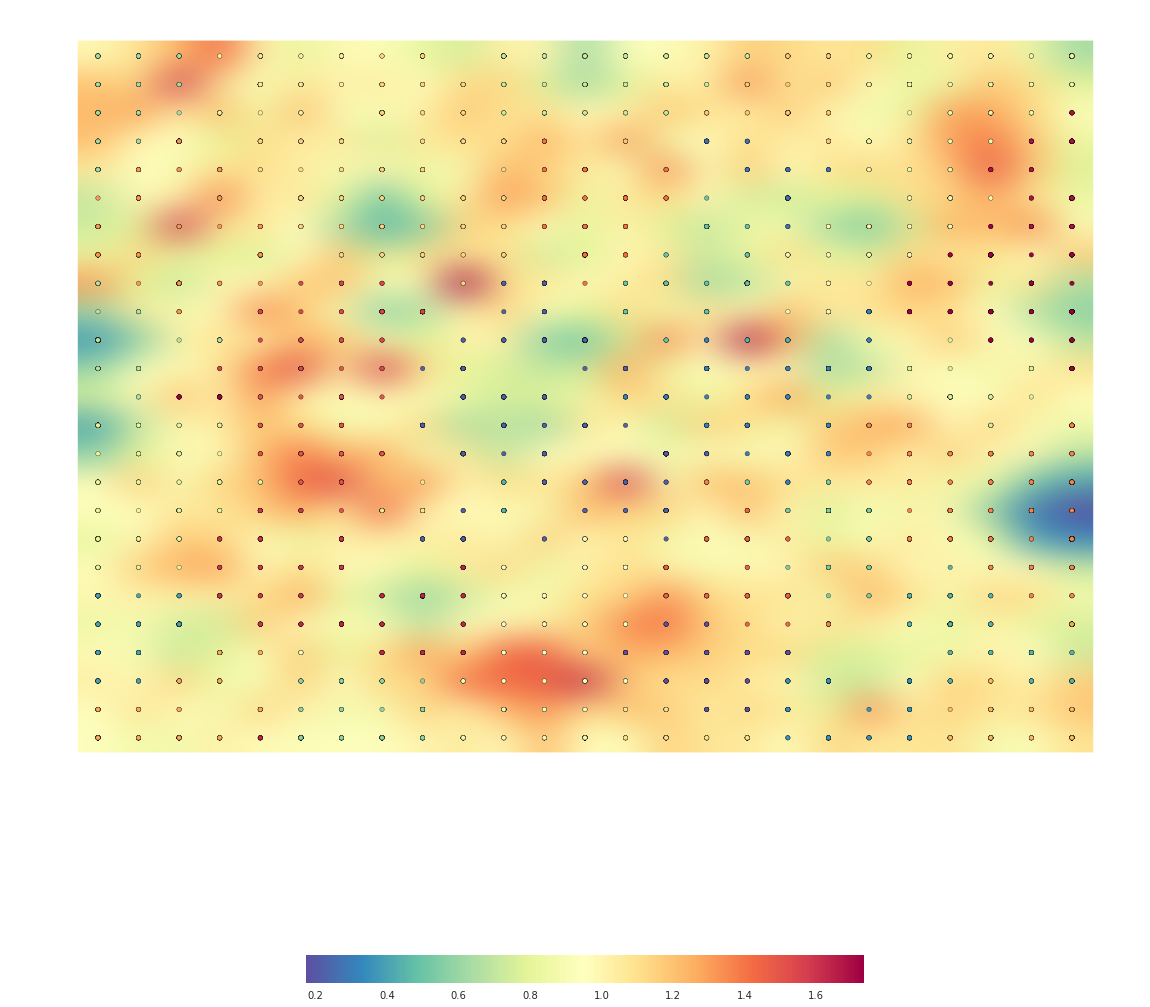




[[10 10 10 19 19 19 19 21 21 21 12 12 12 12 12 12 12 22 22 15 15 15 15 15
  15]
 [10 10 10 19 19 19 19 21 21 21 12 12 12 12 12 12 22 22 22 15 15 15 15 15
  15]
 [10 10 10 19 19 19 21 21 21 21 12 12 12 12 12 22 22 22 22 15 15 15 15 15
  33]
 [10 10 25 25 21 21 21 21 21 21 21 27 27 22  2  2  2 22 22 15 15 15 15 33
  33]
 [10 25 25 25 21 21 21 21 21 21 21 27 27 27 27  2  2  2  2 18 15 15 33 33
  33]
 [25 25 25 25 21 21 21 21 21 21 21 27 27 27 27  7  2  2  2 18 18 18 18 33
  33]
 [25 25 25 25 25 21 21 21 21 21 21 27 27 27  7  7  7  2 18 18 18 18 34 33
  33]
 [25 25 25 25 25 25 21 21 21 21 21 27 27 27  7  7  7 18 18 18 18 34 34 34
  34]
 [11 25 25 25 25 30 30 30 30 21  1  1 27  7  7  7  7  7 18 18 34 34 34 34
  34]
 [11 11 25 11 30 30 30 30 30 30  1  1  1  7  7  7  7 18 18  3 34 34 34 34
  34]
 [11 11 11 11 30 30 30 30 30  1  1  1  1  1  7  3  6  6  3  3 13 13 34 34
  34]
 [11 11 11 30 30 30 29 30  1  1  1  1  1  1  3  3  3  3  3  3 13 13 13 13
  34]
 [14 11 34 34 29 29 29 29  1  1  1  1

In [23]:
n_clusters = 35

algorithm = KMeans(n_clusters=n_clusters)
som.cluster(algorithm=algorithm)

som.view_umatrix(bestmatches=True,figsize=(20, 20),colorbar=True) 

clusters = som.clusters

print '\n\n\n',clusters,'\n\n\n'

clusters_sorted = np.unique(clusters, return_index = True, return_counts = True)
print 'Clusters sorted by increasing number of neurons:\n',clusters_sorted[0]
print 'Cluster Starting Index:\n',clusters_sorted[1]
print 'Number Of Neurons Per Cluster:\n',clusters_sorted[2]

## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.

In [24]:
# TODO the above!
joblib.dump(som, 'som.pkl') 
joblib.dump(clusters, 'clusters.pkl')
joblib.dump(bmus_unique, 'bmus_unique.pkl') 

!ls -l

som = joblib.load('corpus_tf_idf.pkl')
bmus_unique = joblib.load('bmus_unique.pkl')
clusters = joblib.load('clusters.pkl')

total 1141032
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users     17695 Jan 18 06:01 bmus_unique.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users  12880215 Jan 18 05:47 catbins.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users  12880215 Jan 18 05:47 categories.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users      5213 Jan 18 06:01 clusters.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users   5867292 Jan 18 05:47 corpus_tf_idf.pkl
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users        29 Nov 27 16:35 doc.txt
drwx------ 2 s440-f39bd962225440-fe8dadcb5f83 users      4096 Dec 18 03:22 MNIST_data
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users       225 Nov 27 16:47 myarray.csv
-rw------- 1 s440-f39bd962225440-fe8dadcb5f83 users 397400881 Jan 18 06:01 som.pkl
drwx------ 3 s440-f39bd962225440-fe8dadcb5f83 users      4096 Nov  6 04:07 tmp


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες στο cluster.

---
**1** . Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [25]:
def print_categories_stats(movies_to_check):
    total_cats = []

    for movie in movies_to_check:
        temp = categories[movie][0]
        temp = temp.split('"')
        temp = filter(lambda a: a != '', temp)
        temp = filter(lambda a: a != ',  ',temp)
        total_cats.extend(temp)

    total_cats_unique = np.unique(total_cats, return_counts = True)
    indices = np.argsort(total_cats_unique[1])
    indices = reversed(indices)
    tot = sum(total_cats_unique[1])

    print '\n\n','-'*25,'Statistics','-'*25

    print '{:<50} {:<20}'.format('Category', 'Percentage')
    print '-'*62
    for i in indices:
        print '{:<50} {:<20}'.format(total_cats_unique[0][i], str(round(total_cats_unique[1][i]*100.0/tot,3))+'%')

---
**2** . Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

In [26]:
def print_cluster_neurons_movies_report(curr_cluster):
    print 'Cluster =',curr_cluster,'\n'
    new_indices = np.where(clusters == curr_cluster)
    new_indices = np.column_stack((new_indices[1],new_indices[0]))
    bmus_right = []
    for i in new_indices:
        if(i in bmus_unique[0]):
            bmus_right.append(i)
    bmus_right = np.array(bmus_right)
    return bmus_right

---
**3** . Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει.    

In [27]:
def neuron_movies_report(curr_cluster):
    curr_bmus = print_cluster_neurons_movies_report(curr_cluster)
    movies_to_check = []

    for bmu in curr_bmus:
        for id in range(0,len(final_set),1):
            if(np.array_equal(bmu,bmus[id])):
                movies_to_check.append(id)
    print 'This cluster contains',len(movies_to_check),'movies:\n\n'
    print '{:<10} {:<50} {:<20}'.format('[ ID ]','Movie', 'Categories\n')
    for movie in movies_to_check:
        print '\n{:<10} {:<50} {:<20}'.format('['+str(movie)+']', titles[movie,0], categories[movie,0])
    print_categories_stats(movies_to_check)

Ας ελέγξουμε για πέντε διαφορετικά clusters τι θα δώσει η κλήση της παραπάνω συνάρτησης. Παρουσιάζονται οι ταινίες που "ανήκουν" στο συγκεκριμένο cluster, καθώς και η στατιστική απεικόνιση όλων των ειδών (κατηγοριών) και των συχνοτήτων τους.

In [28]:
clusters_to_check = random.sample(range(1, n_clusters), 5)

for curr_cluster in clusters_to_check:
    neuron_movies_report(curr_cluster)
    print '\n\n','-'*62,'\n\n'

Cluster = 22 

This cluster contains 78 movies:


[ ID ]     Movie                                              Categories
         

[444]      Arizona Dream                                      "Indie",  "Comedy-drama",  "Fantasy",  "Comedy",  "Drama",  "Romantic drama",  "Romance Film",  "Adventure"

[455]      Surviving Desire                                   "Romantic comedy",  "Indie",  "Comedy-drama",  "Drama",  "Comedy",  "Romantic drama",  "Romance Film"

[2675]     Skipped Parts                                      "Romantic comedy",  "Indie",  "Comedy-drama",  "Period piece",  "Coming of age",  "Comedy",  "Drama",  "Romantic drama",  "Romance Film",  "Teen"

[2879]     Love Jones                                         "Romantic comedy",  "Indie",  "Comedy-drama",  "Drama",  "Comedy",  "Romantic drama",  "Romance Film"

[3788]     Four Eyed Monsters                                 "Romantic comedy",  "Indie",  "Comedy-drama",  "Drama",  "Romantic drama",  "Romance Film",  "


[4629]     Tsotsi                                             "Crime Fiction",  "Drama",  "World cinema",  "Crime Drama"

[2411]     Made in Britain                                    "Crime Fiction",  "Crime Drama",  "Television movie",  "Short Film",  "Drama",  "Juvenile Delinquency Film"

[2437]     New Jersey Drive                                   "Crime Fiction",  "Action/Adventure",  "Drama",  "Juvenile Delinquency Film",  "Crime Drama"

[3558]     The Angels Wash Their Faces                        "Crime Fiction",  "Drama",  "Black-and-white",  "Juvenile Delinquency Film",  "Crime Drama"

[2527]     Animal Factory                                     "Crime Fiction",  "Drama",  "Prison"

[2748]     Gangs of New York                                  "Crime Fiction",  "Gangster Film",  "Costume drama",  "Historical fiction",  "Epic",  "Period piece",  "Drama",  "Political drama",  "Historical drama"

[3042]     Night Falls on Manhattan                           "Crime Fiction",  

[4228]     La Señal                                          "Drama",  "Indie"   

[4335]     Monobloc                                           "Drama",  "Indie"   

[4422]     How I Got Lost                                     "Drama",  "Indie"   

[4620]     Welcome to the Rileys                              "Marriage Drama",  "Drama",  "Indie"

[4644]     Sweet Nothing                                      "Drama",  "Indie",  "Addiction Drama"

[4773]     Always Brando                                      "Drama",  "Indie"   

[4776]     September                                          "Drama",  "Indie"   

[4966]     Liberty Kid                                        "Drama",  "Indie"   

[1512]     Chasing a Dream                                    "Sports",  "Drama",  "Indie"

[1537]     Judgment                                           "Drama",  "Indie",  "Courtroom Drama"

[1731]     The Whole Shootin' Match                           "Drama",  "Comedy of manners",  "Comedy-d

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

# Τελική παράδοση άσκησης
- Μαζί Θα παραδώσετε τα joblib dumps των τελικών `corpus_tf_idf.pkl` και `som.pkl` (μεγάλος χάρτης - 5000 ταινίες) που θα χρησιμοποιήσετε.  
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στο dump του χάρτη που θα μας παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας.